In [ ]:
import pandas as pd
import nannyml as nml
from IPython.display import display
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

reference_df, analysis_df, analysis_target_df = nml.load_synthetic_car_loan_dataset()

analysis_target_df.head(3)

,repaid
0,True
1,True
2,True


In [ ]:
print(analysis_target_df.head(3).to_markdown(tablefmt="grid"))

+----+----------+
|    |   repaid |
+====+==========+
|  0 |        1 |
+----+----------+
|  1 |        1 |
+----+----------+
|  2 |        1 |
+----+----------+


In [ ]:
analysis_with_targets = analysis_df.merge(analysis_target_df, left_index=True, right_index=True)

display(analysis_with_targets.head(3))

,car_value,salary_range,debt_to_income_ratio,loan_length,repaid_loan_on_prev_car,size_of_downpayment,driver_tenure,timestamp,y_pred_proba,y_pred,repaid
0,12638.0,0 - 20K €,0.487926,21.0,False,10%,4.224628,2018-10-30 18:00:00.000,0.99,True,True
1,52425.0,20K - 20K €,0.672183,20.0,False,40%,4.963103,2018-10-30 18:08:43.152,0.98,True,True
2,20369.0,40K - 60K €,0.703090,19.0,True,40%,4.588951,2018-10-30 18:17:26.304,0.98,True,True


In [ ]:
print(analysis_with_targets.head(3).to_markdown(tablefmt="grid"))

+----+-------------+----------------+------------------------+---------------+---------------------------+-----------------------+-----------------+-------------------------+----------------+----------+----------+
|    |   car_value | salary_range   |   debt_to_income_ratio |   loan_length | repaid_loan_on_prev_car   | size_of_downpayment   |   driver_tenure | timestamp               |   y_pred_proba | y_pred   | repaid   |
+====+=============+================+========================+===============+===========================+=======================+=================+=========================+================+==========+==========+
|  0 |       12638 | 0 - 20K €      |               0.487926 |            21 | False                     | 10%                   |         4.22463 | 2018-10-30 18:00:00.000 |           0.99 | True     | True     |
+----+-------------+----------------+------------------------+---------------+---------------------------+-----------------------+--------------

In [ ]:
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='repaid',
    timestamp_column_name='timestamp',
    metrics=['roc_auc'],
    chunk_size=5000,
    problem_type='classification_binary',
)


In [ ]:
estimator.fit(reference_df)

results = estimator.estimate(analysis_df)

results_df = results.filter(period='analysis').to_df()

In [ ]:
print(results_df.head(3).to_markdown(tablefmt="grid"))

+----+--------------------+----------------------------+----------------------------+--------------------------+---------------------------+----------------------------+-----------------------+------------------------+---------------------------------+---------------------------+--------------------------------------------+--------------------------------------------+----------------------------------+----------------------------------+------------------------+
|    | ('chunk', 'key')   |   ('chunk', 'chunk_index') |   ('chunk', 'start_index') |   ('chunk', 'end_index') | ('chunk', 'start_date')   | ('chunk', 'end_date')      | ('chunk', 'period')   |   ('roc_auc', 'value') |   ('roc_auc', 'sampling_error') |   ('roc_auc', 'realized') |   ('roc_auc', 'upper_confidence_boundary') |   ('roc_auc', 'lower_confidence_boundary') |   ('roc_auc', 'upper_threshold') |   ('roc_auc', 'lower_threshold') | ('roc_auc', 'alert')   |
+====+====================+============================+============

In [ ]:
target_col = 'repaid'
pred_score_col = 'y_pred_proba'
actual_performance = []

for idx in results_df.index:
    start_index, end_index = results_df.loc[idx, ('chunk', 'start_index')], results_df.loc[idx, ('chunk', 'end_index')]
    sub = analysis_with_targets.loc[start_index:end_index]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    results_df.loc[idx, ('roc_auc', 'actual')] = actual_perf

results_df.head(3).iloc[:3, [0, 1,-1]]

chunk               roc_auc
             key chunk_index    actual
0       [0:4999]           0  0.970962
1    [5000:9999]           1  0.970248
2  [10000:14999]           2  0.976282

In [ ]:
print(results_df.head(3).iloc[:3, [0, 1,-1]].to_markdown(tablefmt="grid"))

+----+--------------------+----------------------------+-------------------------+
|    | ('chunk', 'key')   |   ('chunk', 'chunk_index') |   ('roc_auc', 'actual') |
+====+====================+============================+=========================+
|  0 | [0:4999]           |                          0 |                0.970962 |
+----+--------------------+----------------------------+-------------------------+
|  1 | [5000:9999]        |                          1 |                0.970248 |
+----+--------------------+----------------------------+-------------------------+
|  2 | [10000:14999]      |                          2 |                0.976282 |
+----+--------------------+----------------------------+-------------------------+


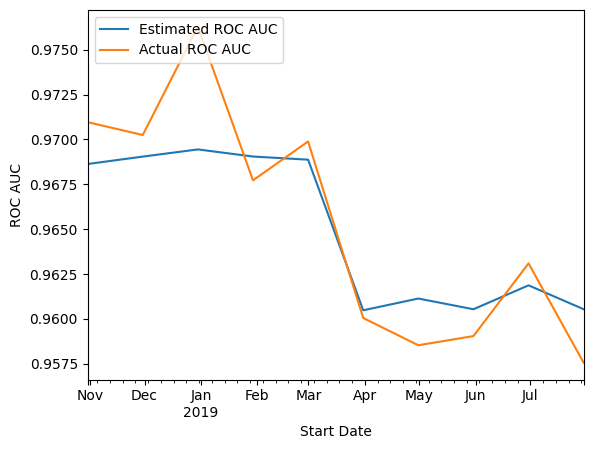

In [ ]:
plot = results_df.loc[:, [('roc_auc', 'value'), ('roc_auc', 'actual'), ('chunk', 'start_date')]].plot(
    y=[('roc_auc', 'value'), ('roc_auc', 'actual')],
    x=('chunk', 'start_date'),
    xlabel='Start Date',
    ylabel='ROC AUC'
)
plot.legend(['Estimated ROC AUC','Actual ROC AUC'],loc='upper left')

plt.show()

In [ ]:
figure = plot.get_figure()
figure.savefig(f'../_static/tutorials/estimated_and_realized_performance/tutorial-binary-car-loan-roc-auc-estimated-and-actual.svg',  bbox_inches = 'tight')
